In [1]:
library(tidyverse)
library(tidymodels)
url <- "https://raw.githubusercontent.com/Xela-debug/datasets/main/Housing.csv"
housing_df <- read_csv(url)
set.seed(2023)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

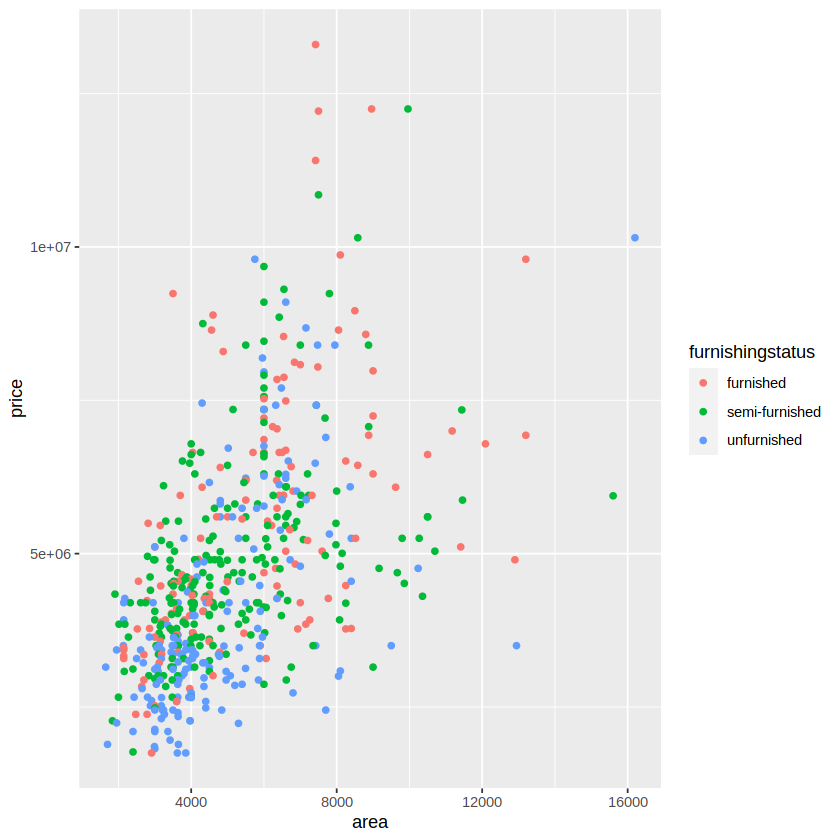

In [2]:
housing_plot <- housing_df |>
    ggplot(aes(x = area, y = price, colour = furnishingstatus)) +
        geom_point()
housing_plot

In [3]:
set.seed(2023)
housing_split <- initial_split(housing_df, prop = 0.75, strata = price)
housing_test <- testing(housing_split)
housing_train <- training(housing_split)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")
housing_recipe <- recipe(price ~ area, data = housing_train)
housing_fit <- workflow() |>
    add_recipe(housing_recipe) |>
    add_model(lm_spec) |>
    fit(data = housing_train)
print(housing_fit)
lm_results <- housing_fit |>
    predict(housing_test) |>
    bind_cols(housing_test) |>
    metrics(truth = area, estimate = .pred)
lm_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)         area  
  2310714.0        478.9  



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4948125
rsq,standard,1
mae,standard,4830219


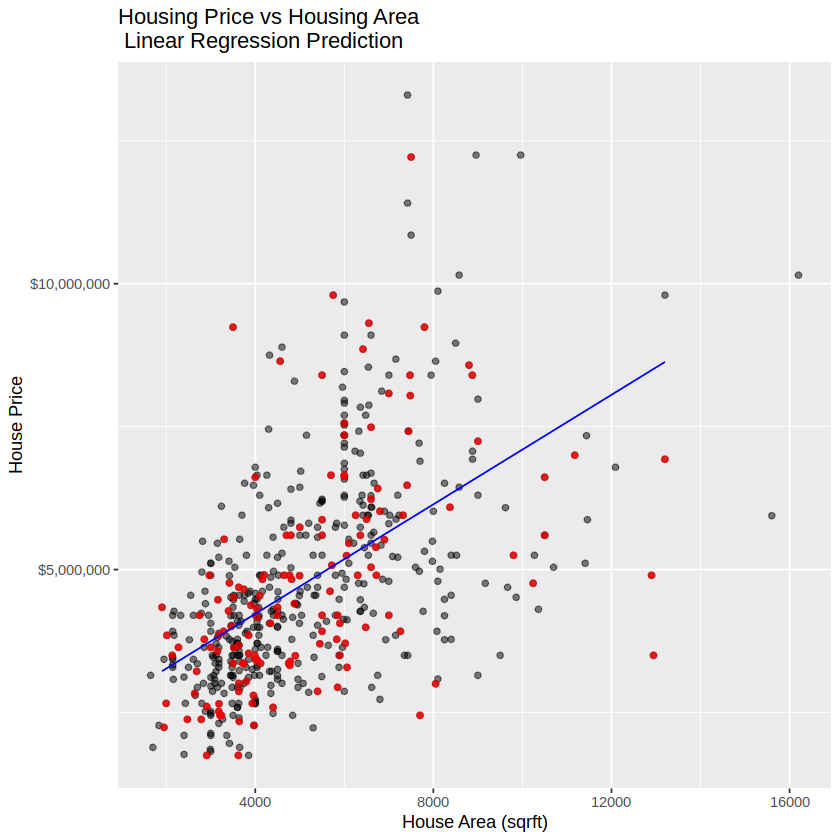

In [4]:
housing_preds <- housing_fit |>
    predict(housing_test) |>
    bind_cols(housing_test)

housing_result_plot <- housing_df |>
    ggplot(aes(x = area, y = price)) +
        geom_point(alpha = 0.5) +
        geom_point(data = housing_test,
                  colour = "red",
                  alpha = 0.7) +
        geom_line(data = housing_preds,
                 mapping = aes(x = area, y = .pred),
                 colour = "blue") +
        labs(x = "House Area (sqrft)", y = "House Price", title = "Housing Price vs Housing Area \n Linear Regression Prediction") +
        scale_y_continuous(labels = dollar_format())
housing_result_plot

In [5]:
housing_preds <- housing_fit |>
    predict(housing_df) |>
    bind_cols(housing_df)

housing_cheap <- housing_preds |>
    filter(price < .pred)
percentage_of_cheaper_homes <- nrow(housing_cheap) / nrow(housing_df) * 100
percentage_of_cheaper_homes

housing_expensive <- housing_preds |>
    filter(price > .pred)
percentage_of_more_expensive_homes <- nrow(housing_expensive) / nrow(housing_df) * 100
percentage_of_more_expensive_homes

[1] 56.14679

[1] 43.85321

In [23]:
knn_housing_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
knn_housing_recipe <- recipe(price ~ area, data = housing_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

gridvals <- tibble(neighbors = seq(1, 100, 4))
knn_housing_vfold <- vfold_cv(housing_train, v = 10, strata = price)

knn_housing_workflow <- workflow() |>
    add_recipe(knn_housing_recipe) |>
    add_model(knn_housing_spec) |>
    tune_grid(resamples = knn_housing_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

knn_housing_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2166200,10,65172.88,Preprocessor1_Model01
5,rmse,standard,1596680,10,128651.19,Preprocessor1_Model02
9,rmse,standard,1509099,10,127309.44,Preprocessor1_Model03
13,rmse,standard,1508496,10,126967.74,Preprocessor1_Model04
17,rmse,standard,1517434,10,120524.39,Preprocessor1_Model05
21,rmse,standard,1513005,10,114735.44,Preprocessor1_Model06
25,rmse,standard,1498041,10,112144.06,Preprocessor1_Model07
29,rmse,standard,1502496,10,111456.61,Preprocessor1_Model08
33,rmse,standard,1504612,10,114659.99,Preprocessor1_Model09


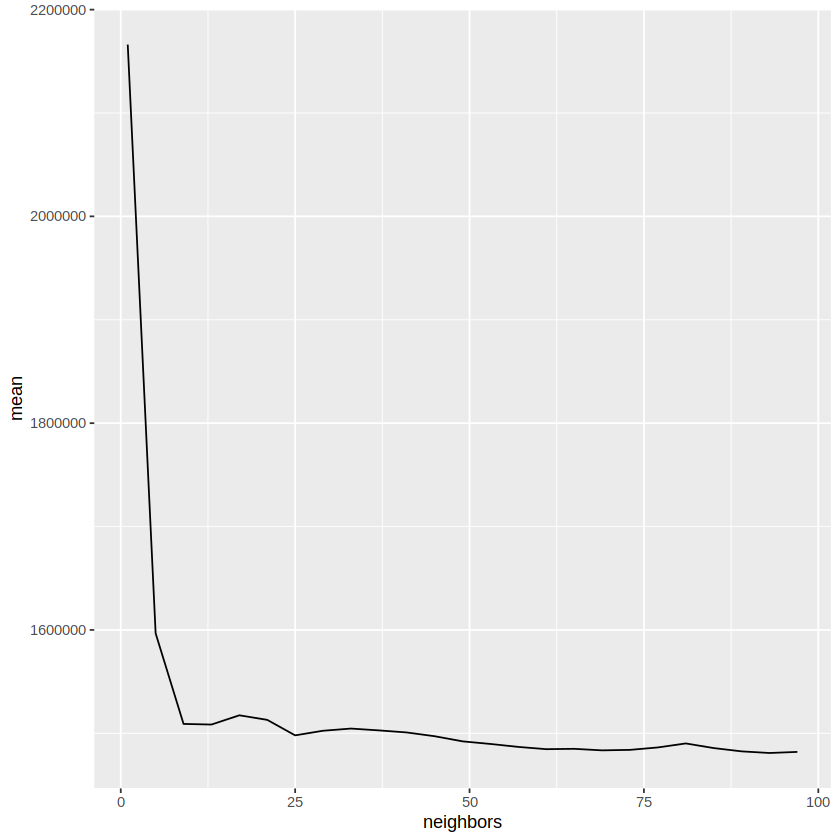

In [24]:
knn_graph <- knn_housing_workflow |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_line()
knn_graph

In [25]:
best_k <- knn_housing_workflow |>
    filter(mean == min(mean)) |>
    pull(neighbors)
best_k

[1] 93

In [27]:
knn_housing_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_housing_workflow <- workflow() |>
    add_recipe(knn_housing_recipe) |>
    add_model(knn_housing_spec) |>
    fit_resamples(resamples = knn_housing_vfold)

knn_housing_workflow |> 
  collect_metrics() 

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,1.480977e+06,10,1.084649e+05,Preprocessor1_Model1
rsq,standard,3.621014e-01,10,3.539435e-02,Preprocessor1_Model1


In [33]:
knn_housing_workflow <- workflow() |>
    add_recipe(knn_housing_recipe) |>
    add_model(knn_housing_spec) |>
    fit(data = housing_train)

knn_predict <- predict(knn_housing_workflow, housing_test) |>
      bind_cols(housing_test)
knn_predict

.pred,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
5996780,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
5578398,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished
6041602,9310000,6550,4,2,2,yes,no,no,no,yes,1,yes,semi-furnished
3695925,9240000,3500,4,2,2,yes,no,no,yes,no,2,no,furnished
6097715,9240000,7800,3,2,2,yes,no,no,no,no,0,yes,semi-furnished
5907247,8855000,6420,3,2,2,yes,no,no,no,yes,1,yes,semi-furnished
4447597,8645000,4560,3,2,2,yes,yes,yes,no,yes,1,no,furnished
6059328,8575000,8800,3,2,2,yes,no,no,no,yes,2,no,furnished
6059328,8400000,8875,3,1,1,yes,no,no,no,no,1,no,semi-furnished


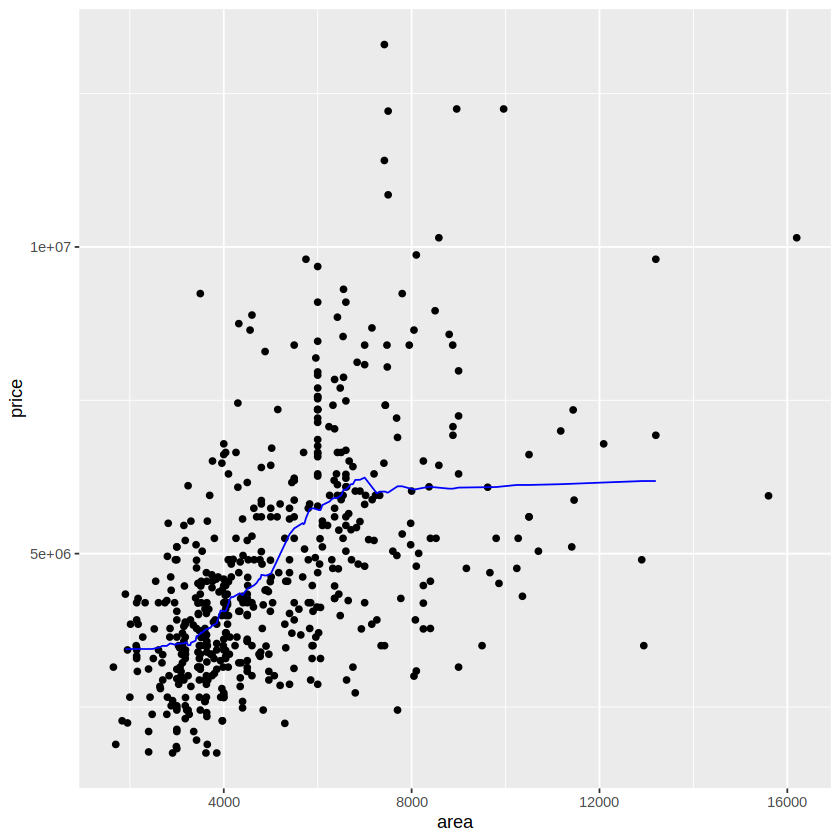

In [39]:
knn_plot <- housing_df |>
    ggplot(aes(x = area, y = price)) +
        geom_point() +
        geom_line(data = knn_predict,
                  mapping = aes(x = area, y = .pred), colour = "blue")
knn_plot